# Virtual Data Set Starter Notebook

#### *Author: Dean Henze, PO.DAAC*

Demonstrates basic functionality of virtual data sets (VDS's). Meant to serve as a modifiable template to explore data sets via this technology.

#### Sections
1. **Obtaining credentials and generating a VDS mapper**: Boiler-plate code to get Earthdata Login credentials and apply them to a VDS. 
2. **Load data, explore, and do computations**: Shows three examples of opening a VDS with Xarray, then exploring and doing computations with Xarray built-in functions.
3. **Alternate workflows other than Xarray built-in functions**: For those who preffer to work in packages other than Xarray, this section shows briefly how to either (a) extract NumPy/Dask arrays from the Xarray Dataset object, or (b) save a subset of the VDS as a local netCDF file.
4. **Working with Level 2 VDS's**: PO.DAAC is testing methods of creating Level 2 VDS's. This section demonstrates working with an L2 scatterometer wind VDS generated at PO.DAAC. It shows how to perform temporal subsetting and spatial search with the VDS.

**Keep in mind**: For out-of-cloud use, you may run into access errors if trying to do computations with more than ~20 years of data due to limitations on the number of simultaneous data requests that can be made at once. For complex or large computations with VDS's, please be in the cloud in the same location as the data (for PO.DAAC this is `us-west-2`).

## Environment

Minimal working installation for Python 3.13.3 environment is

```
fsspec==2024.10.0
earthaccess==0.11.0
virtualizarr==1.2.0
xarray==2025.1.2
zarr==2.18.4
kerchunk==0.2.7
dask==2024.5.2
h5netcdf==1.3.0
netCDF4==1.7.2
matplotlib==3.9.2
jupyterlab==4.4.2
```

In [1]:
# Filesystem management 
import fsspec
import earthaccess

# Data handling
import numpy as np
import xarray as xr

# Other
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Obtaining credentials and generating a VDS mapper

Similarly to any access method for NASA Earthdata, access via VDS's still requires Earthdata Login credentials. Fortunately earthaccess makes this a one-liner. ***Rerun this line each hour to renew your credentials. If you are doing computations in later sections and suddenly hit access errors, you likely need to rerun this line.***

In [2]:
earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


The remaining task of defining some access keywords and mapper to the VDS is generic and can be wrapped into a function (no modification needed). The mapper will contain all the required access credentials and can be passed directly to xarray. In the future this step will likely be built into to earthaccess but for now we must define it in the notebook. The only inputs to the function are:

1. The link to the VDS reference file.
2. Whether or not you are accessing the data in the cloud in the same region as the data. For most beginning users this argument will be set to **False**.

In [3]:
def get_vds_mapper(vds_link, in_cloud_region=False):
    """
    Produces a virtudal dataset mapper that can be passed to xarray. 
    
    * vds_link: str, link to the mapper
    * in_cloud_region: bool, True if in cloud in the same region as the data, 
        False otherwise.
    """

    if in_cloud_region:
        fs_data = earthaccess.get_s3_filesystem(daac="PODAAC")
        remote_protocol = "s3"
    else:
        fs_data = earthaccess.get_fsspec_https_session()
        # We set this header to identify usage of the VDS. This helps us support continued development. 
        fs_data.client_kwargs['headers']['User-Agent'] = "virtual-dataset-consumer"
        remote_protocol = "https"
    
    storage_opts = {"fo": vds_link, "remote_protocol": remote_protocol, "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    return fs_ref.get_mapper('')

## 2. Load data, explore, and do computations

The protocol to open the data will be identical for each collection. This section demonstrates the procedure for three data sets, then does some basic computations. 

The key action item is locating the VDS file link. In the future there will pathways to discover this information via data set landing pages and CMR metadata searches, but for now, please consult the table of VDS reference file links. If you are out of cloud, make sure the VDS link is for https endpoints and not s3 endpoints.

Loading the data is a one-liner using Xarray. At this point, the ability to utilize the data is limited only by the user's knowledge of the Xarray package, or subsetting and loading a portion of the data into your package of choice.

## 2.1 OSTIA-UKMO-L4-GLOB-REP-v2.0

Level 4 sea surface temperature data set, one timestamp per file.

#### Load data

In [4]:
## Modify vds_link for your desired data set. If in-cloud, set in_cloud_region to True:
vds_link = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/OSTIA-UKMO-L4-GLOB-REP-v2.0/OSTIA-UKMO-L4-GLOB-REP-v2.0_virtual_https.json"
vds_mapper = get_vds_mapper(vds_link, in_cloud_region=False)

In [5]:
%%time

## No modification needed!
data = xr.open_dataset(
    vds_mapper, engine="zarr", chunks={},
    backend_kwargs={"consolidated": False}
)
data

CPU times: user 530 ms, sys: 55.5 ms, total: 586 ms
Wall time: 798 ms


<xarray.Dataset> Size: 11TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    mask              (time, lat, lon) float32 2TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (12/39)
    Conventions:                CF-1.4, ACDD-1.3
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    summary:                    A merged, multi-sensor L4 Foundation SST product
    references:                 Donlon, C.J., Martin, M., Stark, J.D., Robert...
    institution:                UKMO
    history:                    Created from sst.nc; obs_anal.nc; seaice.nc
    ...                         ...
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

#### Plot global sea surface temperature for first timestep

CPU times: user 3.04 s, sys: 286 ms, total: 3.33 s
Wall time: 6.26 s


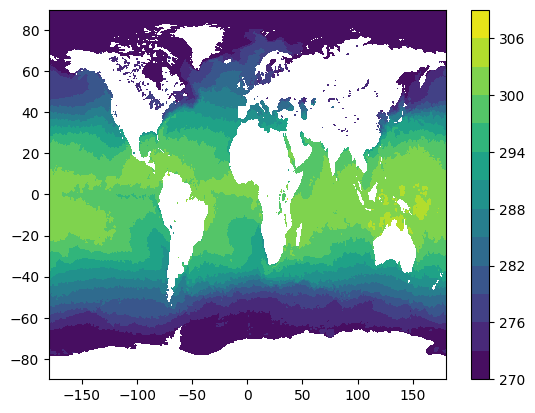

In [6]:
%%time

sst_t0 = data["analysed_sst"].isel(time=0)
plt.figure()
plt.contourf(sst_t0["lon"], sst_t0["lat"], sst_t0.values, levels=np.arange(270, 310, 3))
plt.colorbar()

#### Time series of regional mean sea surface temperature

Subset to 10 x 10 degree window off the USA northwest coast, compute mean over this window for each timestep. Currently the time bounds are set for the first decade of data.

In [7]:
time_bounds = ("1982-01-02T00:00:00", "1992-01-02T00:00:00")
lon_bounds = (-135,-125)  # for -180 to 180 domain
lat_bounds = (35, 45)

In [8]:
data_subset = data.sel(time=slice(*time_bounds)).sel(lon=slice(*lon_bounds), lat=slice(*lat_bounds))
data_subset

<xarray.Dataset> Size: 4GB
Dimensions:           (time: 3652, lat: 200, lon: 200)
Coordinates:
  * lat               (lat) float32 800B 35.03 35.08 35.12 ... 44.88 44.92 44.97
  * lon               (lon) float32 800B -135.0 -134.9 -134.9 ... -125.1 -125.0
  * time              (time) datetime64[ns] 29kB 1982-01-02T12:00:00 ... 1992...
Data variables:
    analysed_sst      (time, lat, lon) float64 1GB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 1GB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    mask              (time, lat, lon) float32 584MB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 1GB dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
Attributes: (12/39)
    Conventions:                CF-1.4, ACDD-1.3
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    summary:                    A merged, multi-sensor L4 Foundation SST product
    references:                 Donlon, C.J., Martin, M., Stark, J.D., Robert...
    institution:                UKMO
    history:                    Created from sst.nc; obs_anal.nc; seaice.nc
    ...                         ...
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [9]:
%%time

region_mean_ts = data_subset["analysed_sst"].mean(dim=("lon","lat")).compute()

CPU times: user 1min 22s, sys: 27.5 s, total: 1min 50s
Wall time: 5min 17s


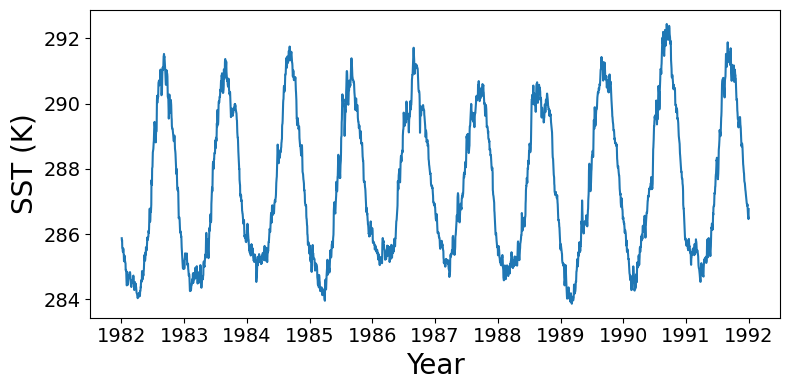

In [10]:
fig = plt.figure(figsize=(8,4), layout="tight")
ax = plt.axes()
plt.plot(region_mean_ts["time"].values, region_mean_ts.values)
plt.xlabel("Year", fontsize=20)
plt.ylabel("SST (K)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

## 2.2 CCMP_WINDS_10M6HR_L4_V3.1

Level 4 dataset with 4 timestamps per file (6-hourly) and longitude range 0-360. The code in this section is mostly identical to the previous section.

#### Load data

In [11]:
## Modify vds_link for your desired data set. If in-cloud, set in_cloud_region to True:
vds_link = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/CCMP_WINDS_10M6HR_L4_V3.1/CCMP_WINDS_10M6HR_L4_V3.1_virtual_https.json"
vds_mapper = get_vds_mapper(vds_link, in_cloud_region=False)

In [12]:
%%time

## No modification needed!
data = xr.open_dataset(
    vds_mapper, engine="zarr", chunks={},
    backend_kwargs={"consolidated": False}
)
data

CPU times: user 170 ms, sys: 8.74 ms, total: 179 ms
Wall time: 179 ms


<xarray.Dataset> Size: 781GB
Dimensions:    (latitude: 720, longitude: 1440, time: 47056)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 376kB 1993-01-02 ... 2025-03-31T18:00:00
Data variables:
    nobs       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    contact:                       Remote Sensing Systems, support@remss.com
    Conventions:                   CF-1.7 ACDD-1.3
    data_structure:                grid
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    institute_id:                  RSS
    ...                            ...
    processing_level:              L4
    keywords:                      EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC W...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform_vocabulary:           GCMD platform keywords
    instrument_vocabulary:         GCMD instrument keywords
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...

#### Plot global ocean surface wind for first timestep

CPU times: user 310 ms, sys: 33.5 ms, total: 343 ms
Wall time: 1.47 s


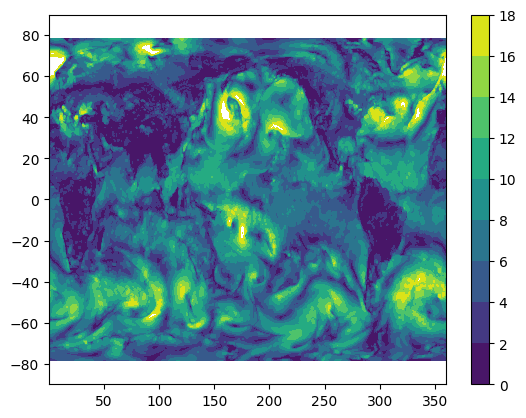

In [13]:
%%time

ws_t0 = data["ws"].isel(time=0)
plt.figure()
plt.contourf(ws_t0["longitude"], ws_t0["latitude"], ws_t0.values, levels=np.arange(0, 20, 2))
plt.colorbar()

#### Time series of regional mean wind speed

Subset to 10 x 10 degree window off the USA northwest coast, compute mean over this window for each day. For the CCMP data set which is 6-hourly, this includes resampling to once daily data. Currently the time bounds are set for the first decade of data.

In [14]:
time_bounds = ("1993-01-02T00:00:00", "2003-01-02T00:00:00")
lon_bounds = (225,235)  # for 0 to 360 domain
lat_bounds = (35, 45)

In [15]:
# First subset by time then by space.
# For temporal subset, also resample the 6-hourly frequency to once daily:
data_subset = data.sel(time=slice(*time_bounds)).resample(time="1d").nearest()
data_subset = data_subset.sel(longitude=slice(*lon_bounds), latitude=slice(*lat_bounds))
data_subset

<xarray.Dataset> Size: 94MB
Dimensions:    (latitude: 40, longitude: 40, time: 3653)
Coordinates:
  * latitude   (latitude) float32 160B 35.12 35.38 35.62 ... 44.38 44.62 44.88
  * longitude  (longitude) float32 160B 225.1 225.4 225.6 ... 234.4 234.6 234.9
  * time       (time) datetime64[ns] 29kB 1993-01-02 1993-01-03 ... 2003-01-02
Data variables:
    nobs       (time, latitude, longitude) float32 23MB dask.array<chunksize=(1, 40, 40), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 23MB dask.array<chunksize=(1, 40, 40), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 23MB dask.array<chunksize=(1, 40, 40), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 23MB dask.array<chunksize=(1, 40, 40), meta=np.ndarray>
Attributes: (12/44)
    contact:                       Remote Sensing Systems, support@remss.com
    Conventions:                   CF-1.7 ACDD-1.3
    data_structure:                grid
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    institute_id:                  RSS
    ...                            ...
    processing_level:              L4
    keywords:                      EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC W...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform_vocabulary:           GCMD platform keywords
    instrument_vocabulary:         GCMD instrument keywords
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...

In [16]:
%%time

region_mean_ts = data_subset["ws"].mean(dim=("longitude","latitude")).compute()

CPU times: user 2min 25s, sys: 1min 10s, total: 3min 36s
Wall time: 9min 48s


In [17]:
# The wind speed seasonal cycle is noisier than e.g. SST, so also compute a 
# monthly rolling mean to plot:
rolling_mean_ts = region_mean_ts.rolling(time=30).mean()

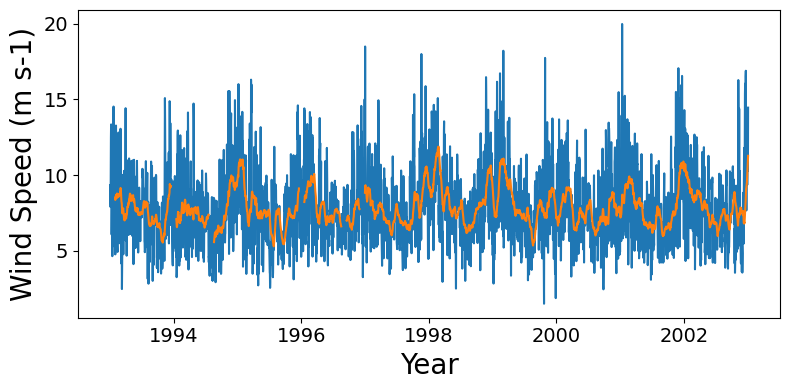

In [18]:
fig = plt.figure(figsize=(8,4), layout="tight")
ax = plt.axes()
plt.plot(region_mean_ts["time"].values, region_mean_ts.values)
plt.plot(rolling_mean_ts["time"].values, rolling_mean_ts.values)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Wind Speed (m s-1)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

## 2.3 ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4

Level 4 model output for ocean temperature and salinity with one timestamp per file and dimensions (time, latitude, longitude, depth). The code in this section is mostly identical to the previous section.

#### Load data

In [19]:
## Modify vds_link for your desired data set. If in-cloud, set in_cloud_region to True:
vds_link = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4/ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4_virtual_https.json"
vds_mapper = get_vds_mapper(vds_link, in_cloud_region=False)

In [20]:
%%time

## No modification needed!
data = xr.open_dataset(
    vds_mapper, engine="zarr", chunks={},
    backend_kwargs={"consolidated": False}
)
data

CPU times: user 316 ms, sys: 17 ms, total: 333 ms
Wall time: 3.46 s


<xarray.Dataset> Size: 985GB
Dimensions:         (time: 9497, Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
    Z_bnds          (Z, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 76kB 1992-01-01T18:00:00 ... 2017-1...
    time_bnds       (time, nv) datetime64[ns] 152kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SALT            (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
    THETA           (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
Attributes: (12/53)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides daily-averaged oce...
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    title:                           ECCO Ocean Temperature and Salinity - Da...

#### Plot global ocean salinity at 5m depth for first timestep

CPU times: user 262 ms, sys: 52.7 ms, total: 315 ms
Wall time: 1.12 s


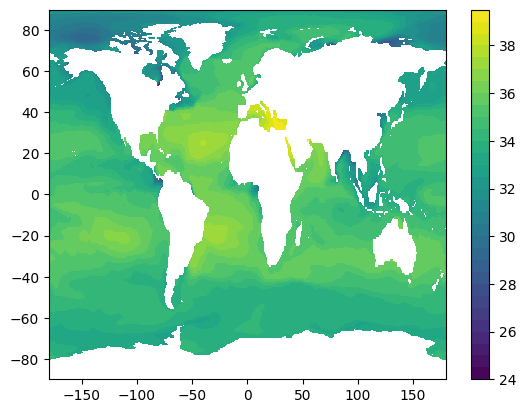

In [21]:
%%time

salt_t0 = data["SALT"].isel(time=0, Z=0)
plt.figure()
plt.contourf(salt_t0["longitude"], salt_t0["latitude"], salt_t0.values, levels=np.arange(24, 40, 0.5))
plt.colorbar()

#### Time series of regional mean ocean salinity at 5m depth

Subset to 10 x 10 degree window off the USA northwest coast, compute mean over this window for each day. Currently the time bounds are set for the first decade of data.

In [22]:
time_bounds = ("1992-01-02T00:00:00", "2002-01-02T00:00:00")
lon_bounds = (-135,-125)  # for -180 to 180 domain
lat_bounds = (35, 45)

In [23]:
# First subset by time then by space (horizontal and vertical):
data_subset = data.sel(time=slice(*time_bounds))
data_subset = data_subset.sel(longitude=slice(*lon_bounds), latitude=slice(*lat_bounds))
data_subset = data_subset.isel(Z=0)
data_subset

<xarray.Dataset> Size: 12MB
Dimensions:         (time: 3653, latitude: 20, longitude: 20, nv: 2)
Coordinates:
    Z               float32 4B -5.0
    Z_bnds          (nv) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
  * latitude        (latitude) float32 80B 35.25 35.75 36.25 ... 44.25 44.75
    latitude_bnds   (latitude, nv) float32 160B dask.array<chunksize=(20, 2), meta=np.ndarray>
  * longitude       (longitude) float32 80B -134.8 -134.2 ... -125.8 -125.2
    longitude_bnds  (longitude, nv) float32 160B dask.array<chunksize=(20, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 29kB 1992-01-02T12:00:00 ... 2002-0...
    time_bnds       (time, nv) datetime64[ns] 58kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SALT            (time, latitude, longitude) float32 6MB dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
    THETA           (time, latitude, longitude) float32 6MB dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
Attributes: (12/53)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides daily-averaged oce...
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    title:                           ECCO Ocean Temperature and Salinity - Da...

In [24]:
%%time

region_mean_ts = data_subset["SALT"].mean(dim=("longitude","latitude")).compute()

CPU times: user 1min 29s, sys: 29.4 s, total: 1min 59s
Wall time: 5min 12s


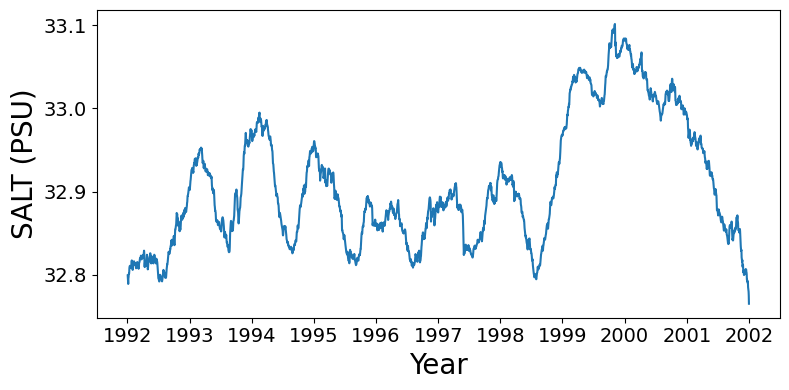

In [25]:
fig = plt.figure(figsize=(8,4), layout="tight")
ax = plt.axes()
plt.plot(region_mean_ts["time"].values, region_mean_ts.values)
plt.xlabel("Year", fontsize=20)
plt.ylabel("SALT (PSU)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

## 3. Alternate workflows other than Xarray built-in functions

#### *Only Section 1 needs to be run prior to this section. Section 2 can be skipped.*

Xarray built-in functions are very convenient for subsetting and many standard computations (grouping, averaging, statistics, etc.). However, if you prefer to use Xarray only to open the data but then work with the data in other ways, this section provides a few methods, using the ECCO model's ocean salinity variable (4D: time, latitude, longitude, depth).

**Open the data using VDS as before**

In [26]:
## Modify vds_link for your desired data set. If in-cloud, set in_cloud_region to True:
vds_link = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4/ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4_virtual_https.json"
vds_mapper = get_vds_mapper(vds_link, in_cloud_region=False)

In [27]:
%%time

data = xr.open_dataset(
    vds_mapper, engine="zarr", chunks={},
    backend_kwargs={"consolidated": False}
)
data

CPU times: user 41.7 ms, sys: 7.25 ms, total: 49 ms
Wall time: 4.62 s


<xarray.Dataset> Size: 985GB
Dimensions:         (time: 9497, Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
    Z_bnds          (Z, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 76kB 1992-01-01T18:00:00 ... 2017-1...
    time_bnds       (time, nv) datetime64[ns] 152kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SALT            (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
    THETA           (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
Attributes: (12/53)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides daily-averaged oce...
    time_coverage_duration:          P1D
    time_coverage_resolution:        P1D
    title:                           ECCO Ocean Temperature and Salinity - Da...

## 3.1 Extract NumPy or Dask arrays from the Xarray Dataset
NumPy arrays are more or less a fundamental data structure for scientific computing in Python. Dask arrays are the analog to NumPy arrays, but for arrays that are too large to load into memory at once at need to be analyzed in chunks. Documentation for both these packages are great and easily findable, e.g. consult the `Resources` section of the `Using Virtual Datasets` chapter of the [PO.DAAC Cookbook](https://podaac.github.io/tutorials/).

**Extracting a NumPy array will take longer than extracting a Dask Array because in the former, the data are fully loaded, while in the latter they are only lazy loaded.**

In [28]:
## Get the first year of salinity data off the USA west coast to work with:
time_bounds = ("1992-01-02T00:00:00", "1993-01-02T00:00:00")
lon_bounds = (-135,-115)
lat_bounds = (25, 45)

In [29]:
## Data is "lazy-subsetted"
data_subset = data.sel(time=slice(*time_bounds)).sel(longitude=slice(*lon_bounds), latitude=slice(*lat_bounds))

In [30]:
%%time
## Load as a numpy array (takes longer because data is fully loaded):
salt_np = data_subset["SALT"].values

CPU times: user 16.7 s, sys: 4.56 s, total: 21.2 s
Wall time: 56.8 s


In [31]:
print(type(salt_np))
print(np.nanmin(salt_np))
print(np.nanmax(salt_np))

<class 'numpy.ndarray'>
31.433891
35.17998


In [32]:
%%time
## Load as a Dask array
salt_da = data_subset["SALT"].data
print(type(salt_da))
salt_da

<class 'dask.array.core.Array'>
CPU times: user 65 μs, sys: 3 μs, total: 68 μs
Wall time: 67.9 μs


dask.array<getitem, shape=(366, 50, 40, 40), dtype=float32, chunksize=(1, 25, 40, 40), chunktype=numpy.ndarray>

In [33]:
%%time
np.nanmin(salt_da).compute()

CPU times: user 16.6 s, sys: 4.84 s, total: 21.5 s
Wall time: 57.4 s


np.float32(31.433891)

## 3.2 Downloading a subset of the data as a netCDF locally

Note that currently the Python package used to create our VDS's (virtualizarr) adds some extra variable-level attributes to the coordinate variables that don't play well with netCDF standards and causes netCDF to complain when we try to save a subset of the VDS to netCDF. This should be fixed in future versions of the virtualizarr package, but for now we include some additional boiler-plate code to deal with these problem attributes. No modification of that code should be necessary from the user.

In [34]:
## Same subset as Section 3.1:
time_bounds = ("1992-01-02T00:00:00", "1993-01-02T00:00:00")
lon_bounds = (-135,-115)
lat_bounds = (25, 45)

In [35]:
data_for_downloading = data.sel(time=slice(*time_bounds)).sel(longitude=slice(*lon_bounds), latitude=slice(*lat_bounds))
data_for_downloading = data_for_downloading["SALT"]

In [36]:
## Function to deal with problem attributes in the VDS before saving to netCDF. No modification should be needed:
def fix_coord_attrs(ds):

    for coord in ds.coords:

        attrs = ds[coord].attrs.copy()
    
        # Convert any booleans to strings:
        for atr, value in attrs.items():
            if type(value) == bool:
                attrs[atr] = str(value)
        
        # Fix the 'preferred_chunks' field (should not be dict):
        if 'preferred_chunks' in attrs:
            pref_chunks = attrs['preferred_chunks']
            if type(pref_chunks) == dict:
                pref_chunks_list = [e[1] for e in pref_chunks.items()]
                attrs['preferred_chunks'] = pref_chunks_list

        # 'chunksizes' attr cannot be None:
        if 'chunksizes' in attrs:
            if attrs['chunksizes'] is None:
                attrs['chunksizes'] = 'none'
    
        if coord == "time":
            # Remove problematic attributes for time encoding,
            # (Likely due to time already being decoded in VDS?)
            if 'units' in attrs:
                del attrs['units']
            if '_FillValue' in attrs:
                del attrs['_FillValue']

        ds[coord].attrs = attrs

    return ds

In [37]:
data_for_downloading = fix_coord_attrs(data_for_downloading)

In [38]:
%%time

data_for_downloading.to_netcdf("data_local_subset.nc")

CPU times: user 16.9 s, sys: 5.62 s, total: 22.5 s
Wall time: 58.7 s


**Then reload the data locally are plot a couple things**

In [39]:
data_local = xr.open_dataset("data_local_subset.nc")
data_local

<xarray.Dataset> Size: 117MB
Dimensions:    (Z: 50, latitude: 40, longitude: 40, time: 366)
Coordinates:
  * Z          (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * latitude   (latitude) float32 160B 25.25 25.75 26.25 ... 43.75 44.25 44.75
  * longitude  (longitude) float32 160B -134.8 -134.2 -133.8 ... -115.8 -115.2
  * time       (time) datetime64[ns] 3kB 1992-01-02T12:00:00 ... 1993-01-01T1...
Data variables:
    SALT       (time, Z, latitude, longitude) float32 117MB ...

**map of salinity at 5 m depth**

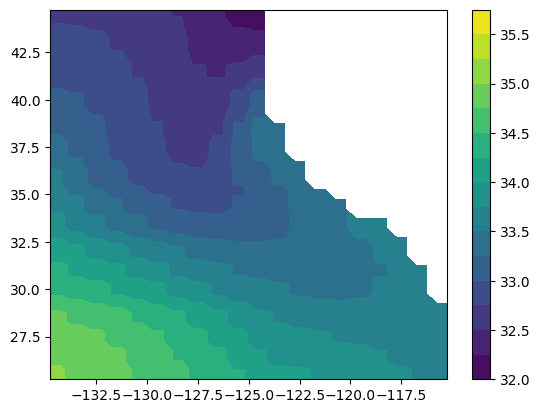

In [40]:
salt_t0z0 = data_local["SALT"].isel(time=0, Z=0)
plt.figure()
plt.contourf(salt_t0z0["longitude"], salt_t0z0["latitude"], salt_t0z0.values, levels=np.arange(32, 36, 0.25))
plt.colorbar()

In [41]:
salt_upper100m = data_local["SALT"].sel(Z=slice(0,-100))
salt_upper100m

<xarray.DataArray 'SALT' (time: 366, Z: 10, latitude: 40, longitude: 40)> Size: 23MB
[5856000 values with dtype=float32]
Coordinates:
  * Z          (Z) float32 40B -5.0 -15.0 -25.0 -35.0 ... -75.0 -85.03 -95.1
  * latitude   (latitude) float32 160B 25.25 25.75 26.25 ... 43.75 44.25 44.75
  * longitude  (longitude) float32 160B -134.8 -134.2 -133.8 ... -115.8 -115.2
  * time       (time) datetime64[ns] 3kB 1992-01-02T12:00:00 ... 1993-01-01T1...
Attributes:
    coverage_content_type:  modelResult
    long_name:              Salinity
    standard_name:          sea_water_salinity
    units:                  1e-3
    valid_min:              16.73577880859375
    valid_max:              41.321231842041016
    comment:                Defined using CF convention 'Sea water salinity i...

**Compute and plot time series of mean salinity profile at top 100 meters from ocean surface**

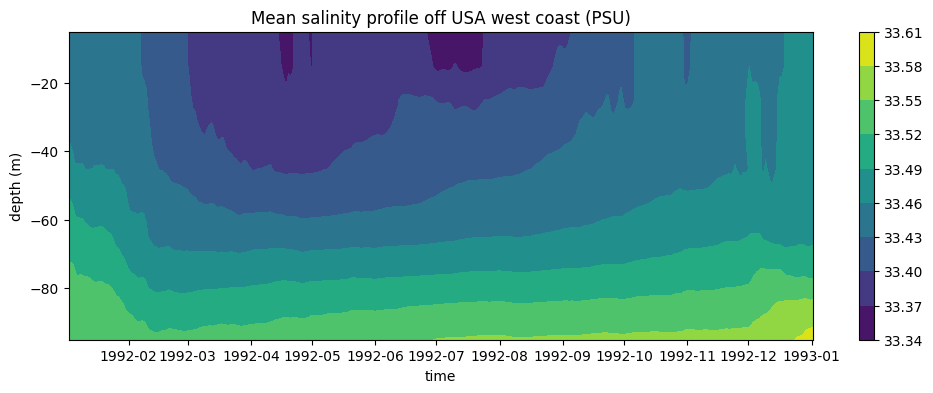

In [42]:
salt_upper100m = data_local["SALT"].sel(Z=slice(0,-100))
salt_mean = salt_upper100m.mean(dim=["longitude", "latitude"])

fig = plt.figure(figsize=(12,4))
plt.contourf(salt_mean["time"], salt_mean["Z"], salt_mean.values.T)
plt.xlabel("time")
plt.ylabel("depth (m)")
plt.title("Mean salinity profile off USA west coast (PSU)")
plt.colorbar()

## 4. Working with Level 2 VDS's

PO.DAAC is testing methods of creating Level 2 VDS's. For datasets with dimensions `along_track`, `cross_track` that are uniform in size across all granules, the current method is to concatenate along a dummy time dimension where each time step corresponds to a granule. The dummy time dimension is assigned cooridnate values of the granule start times. This section shows how to perform temporal subsetting and spatial search with the VDS.

The dataset demo'd here is a wind + wind stress scatterometer product `SCATSAT1_ESDR_L2_WIND_STRESS_V1.1`. Each granule corresponds roughly to one orbit, so the dummy time dimension is labelled `orbit_segment_start_time` and assigned the values of each granule start time.

In [9]:
shortname = "SCATSAT1_ESDR_L2_WIND_STRESS_V1.1"

In [4]:
%%time
vds_link = ("https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/"
            "SCATSAT1_ESDR_L2_WIND_STRESS_V1.1/SCATSAT1_ESDR_L2_WIND_STRESS_V1.1_virtual_s3_concat-time.json")
vds_mapper = get_vds_mapper(vds_link, in_cloud_region=True)
data_vds = xr.open_dataset(
    vds_mapper, engine="zarr", chunks={},
    backend_kwargs={"consolidated": False}
)
data_vds

CPU times: user 1.48 s, sys: 254 ms, total: 1.73 s
Wall time: 7.53 s


<xarray.Dataset> Size: 935GB
Dimensions:                        (orbit_segment_start_time: 13145,
                                    along_track: 3248, cross_track: 152)
Coordinates:
    lat                            (orbit_segment_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    lon                            (orbit_segment_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
  * orbit_segment_start_time       (orbit_segment_start_time) datetime64[ns] 105kB ...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (orbit_segment_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (orbit_segment_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (orbit_segment_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_error        (orbit_segment_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_uncorrected  (orbit_segment_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (orbit_segment_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_magnitude          (orbit_segment_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_magnitude_error    (orbit_segment_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u                  (orbit_segment_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (orbit_segment_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (orbit_segment_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (orbit_segment_start_time, along_track, cross_track) float32 26GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

### Temporal Subsetting

In [5]:
tstart = "2018-07-01T00:00:00"
tend = "2019-07-01T00:00:00"

In [6]:
%%time
data_tsub = data_vds.sel(orbit_segment_start_time = slice(np.datetime64(tstart), np.datetime64(tend)))
data_tsub

CPU times: user 786 ms, sys: 27.3 ms, total: 814 ms
Wall time: 813 ms


<xarray.Dataset> Size: 314GB
Dimensions:                        (orbit_segment_start_time: 4416,
                                    along_track: 3248, cross_track: 152)
Coordinates:
    lat                            (orbit_segment_start_time, along_track, cross_track) float32 9GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    lon                            (orbit_segment_start_time, along_track, cross_track) float32 9GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
  * orbit_segment_start_time       (orbit_segment_start_time) datetime64[ns] 35kB ...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (orbit_segment_start_time, along_track, cross_track) float32 9GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (orbit_segment_start_time, along_track, cross_track) float32 9GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (orbit_segment_start_time, along_track, cross_track) float32 9GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_error        (orbit_segment_start_time, along_track, cross_track) float32 9GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_uncorrected  (orbit_segment_start_time, along_track, cross_track) float32 9GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (orbit_segment_start_time, along_track, cross_track) float32 9GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_magnitude          (orbit_segment_start_time, along_track, cross_track) float32 9GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_magnitude_error    (orbit_segment_start_time, along_track, cross_track) float32 9GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u                  (orbit_segment_start_time, along_track, cross_track) float32 9GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (orbit_segment_start_time, along_track, cross_track) float32 9GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (orbit_segment_start_time, along_track, cross_track) float32 9GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (orbit_segment_start_time, along_track, cross_track) float32 9GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

### Spatial Search

In [10]:
bbox_pm180 = (-20, -20, 0, 0)  # bounding box over longitude range -180, 180.
bbox_0360 = (340, -20, 360, 0)  # bounding box over longitude range 0, 360.

In [11]:
# Locate granule metadata in bbox of interest:
granule_info_bbox = earthaccess.search_data(
    short_name=shortname,
    bounding_box = bbox_pm180,
    )

In [12]:
# Get granule start times from granule search. Will be used to subset from the VDS:
datetimes_str = [g['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'][:-1] for g in granule_info_bbox]  # -1 to remove "Z" at end.
datetimes_obj = [np.datetime64(dts) for dts in datetimes_str]

**The above `datetimes_obj` list can be used to subset the VDS along the `orbit_segment_start_time` dimension, since that dimension was assigned the granule start times.**

In [13]:
%%time
data_vds_bbox = data_vds.sel(orbit_segment_start_time = datetimes_obj)
data_vds_bbox

CPU times: user 561 ms, sys: 13.5 ms, total: 574 ms
Wall time: 574 ms


<xarray.Dataset> Size: 192GB
Dimensions:                        (orbit_segment_start_time: 2701,
                                    along_track: 3248, cross_track: 152)
Coordinates:
    lat                            (orbit_segment_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    lon                            (orbit_segment_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
  * orbit_segment_start_time       (orbit_segment_start_time) datetime64[ns] 22kB ...
Dimensions without coordinates: along_track, cross_track
Data variables: (12/34)
    cross_track_wind_speed_bias    (orbit_segment_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    distance_from_coast            (orbit_segment_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction              (orbit_segment_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_error        (orbit_segment_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_direction_uncorrected  (orbit_segment_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    en_wind_speed                  (orbit_segment_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    ...                             ...
    wind_stress_magnitude          (orbit_segment_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_magnitude_error    (orbit_segment_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u                  (orbit_segment_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_u_error            (orbit_segment_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v                  (orbit_segment_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
    wind_stress_v_error            (orbit_segment_start_time, along_track, cross_track) float32 5GB dask.array<chunksize=(1, 3248, 152), meta=np.ndarray>
Attributes: (12/27)
    Conventions:               CF-1.8, ACDD-1.3, ISO-8601
    ShortName:                 SCATSAT1_ESDR_L2_WIND_STRESS_V1.1
    creator_name:              Svetla Hristova-Veleva, Bryan Stiles, Alexande...
    creator_type:              institution
    geospatial_lat_max:        89.99N
    geospatial_lat_min:        -89.99N
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v78
    summary:                   This project is funded by NASA’s Making Earth ...
    time_coverage_duration:    P0DT1H41M0S
    time_coverage_resolution:  P0DT0H0M30S
    title:                     SCATSAT-1 Scatterometer Inter-Calibrated ESDR ...
    version_id:                1.1

**Check data in the first few timesteps to confirm spatial search worked**

CPU times: user 5.07 s, sys: 834 ms, total: 5.9 s
Wall time: 16.9 s


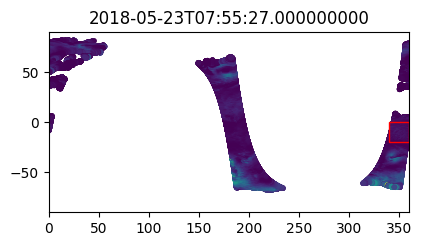

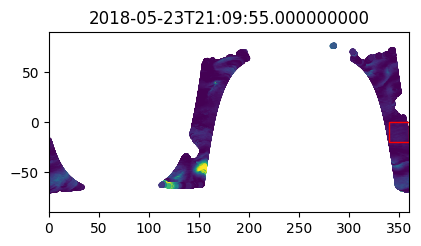

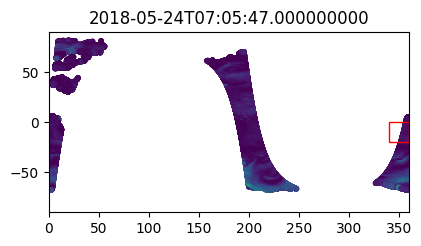

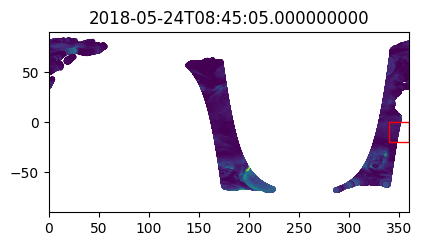

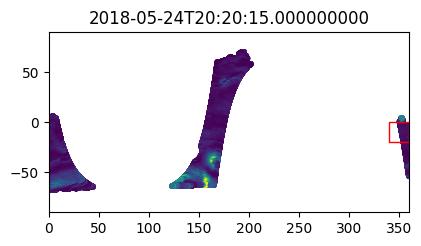

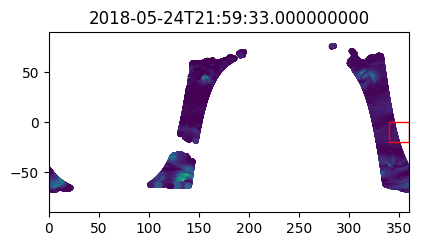

In [48]:
%%time

i_plot_start = 99
i_plot_end = 105
figs = [plt.figure(figsize=(4,2)) for n in range(i_plot_end - i_plot_start)]
axes = [f.add_axes((0, 0, 0.9, 0.9)) for f in figs]

bbox_width = bbox_0360[2] - bbox_0360[0]
bbox_height = bbox_0360[3] - bbox_0360[1]

for ax, dt in zip(axes, data_vds_bbox["orbit_segment_start_time"].values[i_plot_start:i_plot_end]):
    data_sub = data_vds_bbox.sel(orbit_segment_start_time = dt)
    bbox_patch = plt.Rectangle(
        (bbox_0360[0], bbox_0360[1]), bbox_width, bbox_height, 
        edgecolor='red', facecolor='none'
    )
    ax.add_patch(bbox_patch)
    ax.set_title(dt)
    ax.scatter(
        data_sub['lon'], data_sub['lat'], c=data_sub['wind_stress_magnitude'], 
        marker='.', zorder=-99, vmin=0, vmax=1.5
    )
    ax.set_xlim([0, 360])
    ax.set_ylim([-90, 90])